# VGG16-based model with CIFAR-10

### Imports and dataset init

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import random

In [2]:
# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available. You can use GPU for PyTorch.")
else:
    print("CUDA is not available. Using CPU for PyTorch.")

CUDA is available. You can use GPU for PyTorch.


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.15)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [5]:
full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform_train)

# Creating train/vali split
train_size = int(0.8 * len(full_trainset))
val_size = len(full_trainset) - train_size
trainset, valset = random_split(full_trainset, [train_size, val_size])

valset.dataset.transform = transform_test  # For validation we switch to transform_test (no augmentation)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform_test)

In [6]:
batch_size = 64

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

### Building CNN

In [7]:
vgg16 = models.vgg16(pretrained=True)

for param in vgg16.features.parameters():
    param.requires_grad = False

# vgg16.classifier[6] = nn.Linear(in_features=4096, out_features=10)  # CIFAR-10 has 10 classes

vgg16.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(4096, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(4096, 10)
)

c:\Users\diogo\Documents\Repos\cifar10-image-classifier\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\diogo\Documents\Repos\cifar10-image-classifier\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
model = vgg16.to(device)

learning_rate = 0.0005

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

### Training loop and eval

In [9]:
num_epochs = 100  # TODO: Add auto stopping criterion if loss is not decreasing
train_losses = []
val_losses = []

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
    
    scheduler.step()

    epoch_loss = running_loss / len(trainloader.dataset)
    train_losses.append(epoch_loss)

    model.eval()
    val_running_loss = 0.0
    
    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * inputs.size(0)
    
    epoch_val_loss = val_running_loss / len(valloader.dataset)
    val_losses.append(epoch_val_loss)

    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{num_epochs}], Training Loss: {epoch_loss:.8f}, Validation Loss: {epoch_val_loss:.8f}")

Epoch [10/100], Training Loss: 0.13008389, Validation Loss: 0.59870752
Epoch [20/100], Training Loss: 0.11312403, Validation Loss: 0.80644764
Epoch [30/100], Training Loss: 0.02626727, Validation Loss: 0.97119195
Epoch [40/100], Training Loss: 0.03486274, Validation Loss: 1.14965924
Epoch [50/100], Training Loss: 0.00904717, Validation Loss: 1.22511259
Epoch [60/100], Training Loss: 0.00669793, Validation Loss: 1.25851764
Epoch [70/100], Training Loss: 0.00546266, Validation Loss: 1.32487398
Epoch [80/100], Training Loss: 0.00414984, Validation Loss: 1.35484207
Epoch [90/100], Training Loss: 0.00280700, Validation Loss: 1.44541700
Epoch [100/100], Training Loss: 0.00118333, Validation Loss: 1.47287792


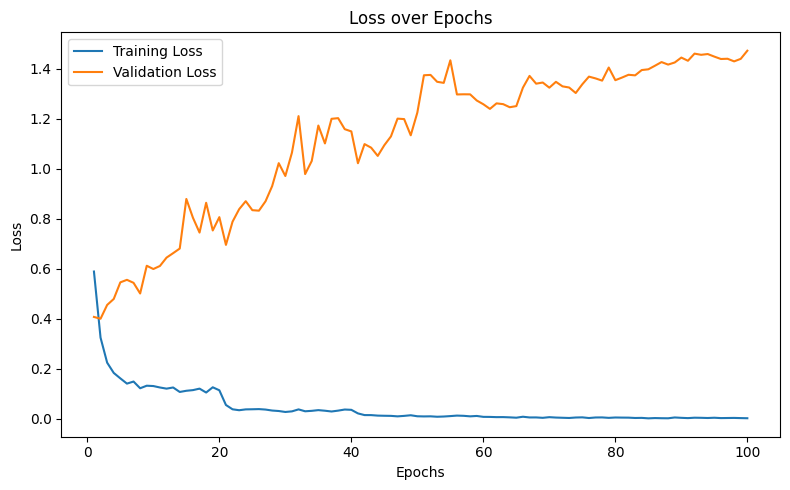

In [10]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
rec = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
print("\nTest Metrics:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-Score: {f1:.4f}")
print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=testset.classes, zero_division=0))


Test Metrics:
Accuracy: 0.8920
Precision: 0.8917
Recall: 0.8920
F1-Score: 0.8917

Classification Report:
               precision    recall  f1-score   support

    airplane       0.90      0.92      0.91      1000
  automobile       0.94      0.94      0.94      1000
        bird       0.88      0.85      0.87      1000
         cat       0.80      0.77      0.79      1000
        deer       0.85      0.88      0.86      1000
         dog       0.85      0.84      0.84      1000
        frog       0.92      0.93      0.92      1000
       horse       0.92      0.90      0.91      1000
        ship       0.93      0.95      0.94      1000
       truck       0.93      0.93      0.93      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

